# Pipeline

## Specifications

In [ ]:
import sys
from utils.setup import SetupPCAnalysis

# argv           = sys.argv[1:]
argv           = ['-c', './nn_config/cfg_pipeline.yml']
# argv           = ['-c', './nn_config/cfg_pipeline_concat.yml']
# argv           = ['-c', './nn_config/cfg_pipeline_climate_invariant.yml']

setup = SetupPCAnalysis(argv)


## ./utils/utils

In [ ]:
import numpy    as np
import numpy.ma as ma
from   math     import pi
from pathlib    import Path
from utils.constants import ANCIL_FILE, FILENAME_PATTERN, SPCAM_Vars # DATA_FOLDER
from neural_networks.cbrain.cam_constants  import *
from netCDF4    import Dataset
import pickle
from collections import deque
from utils.utils import get_normalized_data, VarData

def generate_results_filename_single(
    var, level, lat, lon, ind_test, experiment, pattern, folder
):
    results_filename = pattern.format(
        var_name=var.name,
        level=level + 1,
        lat=int(lat),
        lon=int(lon),
        ind_test=ind_test,
        experiment=experiment,
    )
    return Path(folder, results_filename)


def load_data(var_list, shifting, experiment, folder, idx_lvls, idx_lats, idx_lons):
    data = list()
    for var in var_list:
        for target_lvl, idx_lvl in idx_lvls:
            norm_data = get_normalized_data(
                var, shifting, experiment, folder, idx_lats, idx_lons, idx_lvl
            )
            if var.dimensions == 3:
                var_data = VarData(var, norm_data, target_lvl)
            elif var.dimensions == 2:
                var_data = VarData(var, norm_data)
            data.append(var_data)

            if var.dimensions == 2:
                break  # Stop loading data after the first level
    return data


def save_results(results, file):
    Path(file).parents[0].mkdir(parents=True, exist_ok=True)
    with open(file, "wb") as f:
        pickle.dump(results, f)
    print(f'Saved results into "{file}"')

## ./utils/pcmci_algorithm

In [ ]:
import numpy as np
import utils.links as links
from utils.constants import TAU_MIN, TAU_MAX
import tigramite
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI

def run_pc_stable(pcmci, selected_links, list_pc_alpha):
    pc_alpha_results = dict()
    for pc_alpha in list_pc_alpha:
        try:
            links = pcmci.run_pc_stable(
                tau_min=TAU_MIN,
                tau_max=TAU_MAX,
                selected_links=selected_links,
                pc_alpha=pc_alpha,
            )
            # "result_parents" will now be a dictionary with only the
            # causal parents for each variable like selected_links, but
            # only with the actual links

            # link_matrix = pcmci.return_significant_links(
            #     pq_matrix=pcmci.p_matrix,
            #     val_matrix=pcmci.val_matrix,
            #     alpha_level=pc_alpha
            # )['link_matrix']

            results = {
                "links": links,
                "p_matrix": pcmci.p_matrix,
                "val_matrix": pcmci.val_matrix,
                # "link_matrix" : link_matrix,
                "var_names": pcmci.var_names,
            }
        except ValueError as e:
            print(e)
            results = {}
        pc_alpha_results[str(pc_alpha)] = results

    return pc_alpha_results


def run_pearsonr(
    dataframe, 
    cond_ind_test,
    list_pc_alpha, 
    TAU_MIN, 
    TAU_MAX, 
    parents, 
    children
):

    parents = set(parents)
    children = set(children)
    pc_alpha_results = dict()

    for pc_alpha in list_pc_alpha:
        try:
            
            links = dict()
            p_matrix = np.zeros([len(dataframe.values[0]),len(dataframe.values[0]),2])
            r_matrix = np.zeros(p_matrix.shape)
            
            # Set the default as all combinations of the selected variables
            for var in [*parents, *children]:
                if var in children:
                    # Children can be caused only by parents and by themselves
                    links_tmp = []
                    for parent in [*parents, *children]:
                        
                        r_matrix[parent,-1,-1], p_matrix[parent,-1,-1] = cond_ind_test(
                            dataframe.values[:,parent],
                            dataframe.values[:,var]
                        )
                        
                        if p_matrix[parent,-1,-1] <= pc_alpha and parent != var:
                            [links_tmp.append((parent, -lag)) for lag in range(TAU_MIN, TAU_MAX + 1)]
                    links[var] = links_tmp
                else:
                    links[var] = []

            results = {
                "links": links,
                "p_matrix": p_matrix,
                "val_matrix": r_matrix,
                "var_names": dataframe.var_names,
            }
    
        except ValueError as e:
            print(e)
            results = {}
        
        pc_alpha_results[str(pc_alpha)] = results

    return pc_alpha_results


def find_links(list_var_data, list_pc_alpha, cond_ind_test, verbosity=0):
    spcam_data, var_names, parents, children = links.prepare_tigramite_data(
        list_var_data
    )

    selected_links = links.select_links(TAU_MIN, TAU_MAX, parents, children)

    # Initialize dataframe object, specify time axis and variable names
    dataframe = pp.DataFrame(
        spcam_data, datatime=np.arange(len(spcam_data)), var_names=var_names
    )
    
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=verbosity)
    
    return run_pc_stable(pcmci, selected_links, list_pc_alpha)


def pearsonr(list_var_data, list_pc_alpha, cond_ind_test, verbosity=0):

    spcam_data, var_names, parents, children = links.prepare_tigramite_data(
        list_var_data
    )

    # Initialize dataframe object, specify time axis and variable names
    dataframe = pp.DataFrame(
        spcam_data, datatime=np.arange(len(spcam_data)), var_names=var_names
    )
    
    return run_pearsonr(dataframe, cond_ind_test, list_pc_alpha, TAU_MIN, TAU_MAX, parents, children)
    

## ./utils/processing.proc_analysis()

In [ ]:
import sys, getopt, yaml, time, datetime
from datetime import datetime as dt
import numpy as np
from pathlib import Path
# import utils.utils as utils
from utils.constants import ANCIL_FILE        # DATA_FOLDER, EXPERIMENT
# from utils.pcmci_algorithm import find_links


def proc_analysis(
    analysis,
    gridpoints,
    var_parents,
    var_children,
    cond_ind_test,
    ind_test_name,
    pc_alphas,
    shifting,
    levels,
    parents_idx_levs,
    children_idx_levs,
    idx_lats,
    idx_lons,
    data_folder,
    experiment,
    output_file_pattern,
    output_folder,
    overwrite,
    verbosity,
):
    if analysis == "single":
        print("Analysis: single")
        print()
        single(
            gridpoints,
            var_parents,
            var_children,
            cond_ind_test,
            ind_test_name,
            pc_alphas,
            shifting,
            levels,
            parents_idx_levs,
            children_idx_levs,
            idx_lats,
            idx_lons,
            data_folder,
            experiment,
            output_file_pattern,
            output_folder,
            overwrite,
            verbosity,
        )
    elif analysis == "concat":
        print("Analysis: concat")
        print()
        concat(
            gridpoints,
            var_parents,
            var_children,
            cond_ind_test,
            ind_test_name,
            pc_alphas,
            levels,
            parents_idx_levs,
            children_idx_levs,
            idx_lats,
            idx_lons,
            data_folder,
            experiment,
            output_file_pattern,
            output_folder,
            overwrite,
            verbosity,
        )
    else:
        raise TypeError(
            "Please specify a valid analysis, i.e., 'single' or 'concat'; stop script"
        )


def single(
    gridpoints,
    var_parents,
    var_children,
    cond_ind_test,
    ind_test_name,
    pc_alphas,
    shifting,
    levels,
    parents_idx_levs,
    children_idx_levs,
    idx_lats,
    idx_lons,
    data_folder,
    experiment,
    output_file_pattern,
    output_folder,
    overwrite,
    verbosity,
):

    ## Processing
    len_grid = len(gridpoints)
    t_start = time.time()
    for i_grid, (lat, lon) in enumerate(gridpoints):

        t_start_gridpoint = time.time()
        data_parents = None

        idx_lat = idx_lats[i_grid]
        idx_lon = idx_lons[i_grid]

        for child in var_children:
            print(f"{dt.now()} Variable: {child.name}")
            if child.dimensions == 2:
                child_levels = [[levels[-1], 0]]
            elif child.dimensions == 3:
                child_levels = children_idx_levs

            for level in child_levels:
                results_file = generate_results_filename_single(
                    child,
                    level[-1],
                    lat,
                    lon,
                    ind_test_name,
                    experiment,
                    output_file_pattern,
                    output_folder,
                )

                if not overwrite and results_file.is_file():
                    print(f"{dt.now()} Found file {results_file}, skipping.")
                    continue  # Ignore this level

                # Only load parents if necessary to analyze a child
                # they stay loaded until the next gridpoint
                if data_parents is None:

                    print(
                        f"{dt.now()} Gridpoint {i_grid+1}/{len_grid}:"
                        f" lat={lat} ({idx_lat}), lon={lon} ({idx_lon})"
                    )

                    print(f"Load Parents (state fields)...")
                    t_before_load_parents = time.time()
                    data_parents = load_data(
                        var_parents,
                        0, # shifting always 0 (no-shifting)
                        experiment,
                        data_folder,
                        parents_idx_levs,
                        idx_lat,
                        idx_lon,
                    )
                    time_load_parents = datetime.timedelta(
                        seconds=time.time() - t_before_load_parents
                    )
                    print(f"{dt.now()} All parents loaded. Time: {time_load_parents}")

                # Process child
                data_child = load_data(
                    [child], shifting, experiment, data_folder, [level], idx_lat, idx_lon
                )
                data = [*data_parents, *data_child]
                
                # Find links
                print(
                    f"{dt.now()} "
                    f"Finding links for {child.name} at level {level[-1]+1}"
                )
                t_before_find_links = time.time()
                if ind_test_name == 'parcorr':
                    results = find_links(data, pc_alphas, cond_ind_test, verbosity)
                elif ind_test_name == 'pearsonr':
                    results = pearsonr(data, pc_alphas, cond_ind_test, verbosity)
                else:
                    print(f"Invalid independence_test: {setup.independence_test}; stop!")
                    sys.exit()
                time_links = datetime.timedelta(
                    seconds=time.time() - t_before_find_links
                )
                total_time = datetime.timedelta(seconds=time.time() - t_start)
                print(
                    f"{dt.now()} Links found. Time: {time_links}"
                    f" Total time so far: {total_time}"
                )

                # Store causal links
                save_results(results, results_file)

        time_point = datetime.timedelta(seconds=time.time() - t_start_gridpoint)
        total_time = datetime.timedelta(seconds=time.time() - t_start)
        print(
            f"{dt.now()} All links in gridpoint found. Time: {time_point}."
            f" Total time so far: {total_time}"
        )
        print()

    print(f"{dt.now()} Execution complete. Total time: {total_time}")

In [ ]:
proc_analysis(
    setup.analysis,
    setup.gridpoints,
    setup.spcam_inputs,
    setup.spcam_outputs,
    setup.cond_ind_test,
    setup.ind_test_name,
    setup.pc_alphas,
    setup.shifting,
    setup.levels,
    setup.parents_idx_levs,
    setup.children_idx_levs,
    setup.idx_lats,
    setup.idx_lons,
    setup.data_folder,
    setup.experiment,
    setup.output_file_pattern,
    setup.output_folder,
    setup.overwrite_pc,
    setup.verbosity_pc
)

# Aggregate results

## Specifications

In [1]:
from utils.setup import SetupPCMCIAggregation
import utils.pcmci_aggregation as aggregation

argv           = ['-c', './nn_config/cfg_pipeline.yml']

setup = SetupPCMCIAggregation(argv)

## Collect results

In [ ]:
collected_results, errors = aggregation.collect_results(setup, reuse=True)
print(aggregation.print_errors(errors))

## Analyze collected results

In [3]:
aggregated_results, var_names_parents = aggregation.aggregate_results(
    collected_results, setup)

## Plots

### Plot Outputs-Inputs metrics 

In [4]:
setup.thresholds = [0.05,0.7]

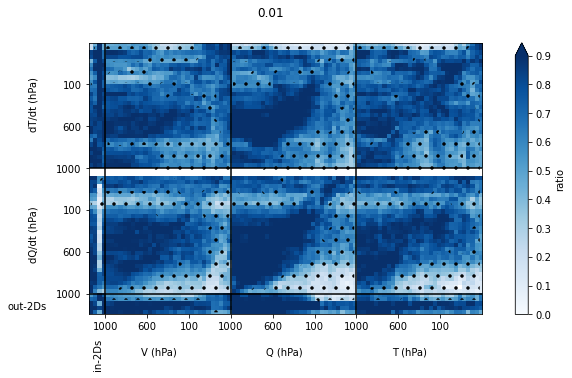

In [5]:
aggregation.plot_matrix_results(
    var_names_parents, 
    aggregated_results, 
    setup, 
    values='percentage', 
    save=False
)
# plot_matrix_results(
#     var_names_parents, 
#     aggregated_results, 
#     setup, 
#     values='percentage', 
#     save=False
# )

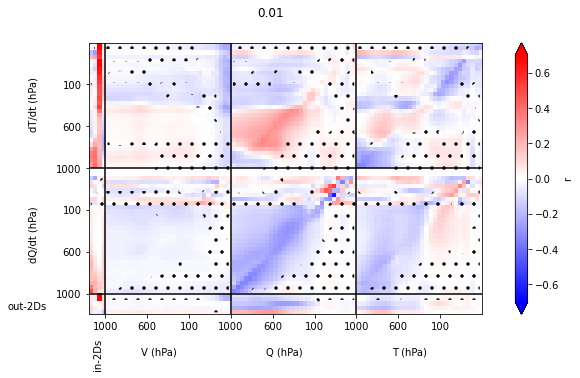

In [6]:
aggregation.plot_matrix_results(
    var_names_parents, 
    aggregated_results, 
    setup, 
    values='val_matrix', 
    save=False
)